# Load Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time

from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Load Data

### Scraping Data from Basketball Reference

In [35]:
def single_player(season,stats = 'regular'):
    url = f'https://www.basketball-reference.com/leagues/NBA_{season}_advanced.html#advanced_stats'
    table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')
    df = pd.read_html(str(table_html))[0]

    df = df.drop('Rk', 1) # drop Rk columns
    
    df.Player = df.Player.str.replace('*','') # remove asterisk on player's name
    df.insert(0,'Season',season) # insert season column
    df = df.apply(pd.to_numeric, errors='coerce').fillna(df) 
    return df

def multiple_player(start_year,end_year,stats):
    sts = stats
    df = single_player(start_year)
    while start_year < end_year:
        time.sleep(4)                
        start_year = start_year + 1
        df = df.append(single_player(start_year,stats = sts))
    return df




def scrape_NBA_team_data(years = [2017, 2018]):
    
    final_df = pd.DataFrame(columns = ["Year", "Team", "W", "L",
                                       "W/L%", "GB", "PS/G", "PA/G",
                                       "SRS", "Playoffs",
                                       "Losing_season"])
    
    # loop through each year
    for y in years:
        # NBA season to scrape
        year = y
        
        # URL to scrape, notice f string:
        url = f"https://www.basketball-reference.com/leagues/NBA_{year}_standings.html"
        
        # collect HTML data
        html = urlopen(url)
        
        # create beautiful soup object from HTML
        soup = BeautifulSoup(html, features="lxml")
        
        # use getText()to extract the headers into a list
        titles = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        
        # first, find only column headers
        headers = titles[1:titles.index("SRS")+1]
        
        # then, exclude first set of column headers (duplicated)
        titles = titles[titles.index("SRS")+1:]
        
        # next, row titles (ex: Boston Celtics, Toronto Raptors)
        try:
            row_titles = titles[0:titles.index("Eastern Conference")]
        except: row_titles = titles
        # remove the non-teams from this list
        for i in headers:
            row_titles.remove(i)
        row_titles.remove("Western Conference")
        divisions = ["Atlantic Division", "Central Division",
                     "Southeast Division", "Northwest Division",
                     "Pacific Division", "Southwest Division",
                     "Midwest Division"]
        for d in divisions:
            try:
                row_titles.remove(d)
            except:
                print("no division:", d)
        
        # next, grab all data from rows (avoid first row)
        rows = soup.findAll('tr')[1:]
        team_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        # remove empty elements
        team_stats = [e for e in team_stats if e != []]
        # only keep needed rows
        team_stats = team_stats[0:len(row_titles)]
        
        # add team name to each row in team_stats
        for i in range(0, len(team_stats)):
            team_stats[i].insert(0, row_titles[i])
            team_stats[i].insert(0, year)
            
        # add team, year columns to headers
        headers.insert(0, "Team")
        headers.insert(0, "Year")
        
        # create a dataframe with all aquired info
        year_standings = pd.DataFrame(team_stats, columns = headers)
        
        # add a column to dataframe to indicate playoff appearance
        year_standings["Playoffs"] = ["Y" if "*" in ele else "N" for ele in year_standings["Team"]]
        # remove * from team names
        year_standings["Team"] = [ele.replace('*', '') for ele in year_standings["Team"]]
        # add losing season indicator (win % < .5)
        year_standings["Losing_season"] = ["Y" if float(ele) < .5 else "N" for ele in year_standings["W/L%"]]
        
        # append new dataframe to final_df
        final_df = pd.concat([final_df,year_standings],axis=0)
    return final_df

def scrape_award_voting(start_year,end_year,award):
    data = pd.DataFrame()
    while start_year <= end_year:
        url = f'https://www.basketball-reference.com/awards/awards_{start_year}.html#{award}'
        table_html = str(BeautifulSoup(urlopen(url), 'html.parser').findAll('table')[0])
        df = pd.read_html(str(table_html))[0]
        df.columns = df.columns.droplevel(0)
        df['Season'] = start_year
        df = df[['Season','Player','Pts Won','Pts Max','Share']]
        data = data.append(df)
        start_year+=1
    return data

In [7]:
df.to_csv('mvp_voting_shares.csv',index=False)

In [8]:
df = scrape_award_voting(1998,2022,'dpoy')

/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_71137/3742092849.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_71137/3742092849.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_71137/3742092849.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_71137/3742092849.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/r_/207_jjvs0mncdjz3

HTTPError: HTTP Error 429: Too Many Requests

In [9]:
df.head()

,Season,Player,Pts Won,Pts Max,Share
0,1998,Michael Jordan,1084.0,1160,0.934
1,1998,Karl Malone,842.0,1160,0.726
2,1998,Gary Payton,431.0,1160,0.372
3,1998,Shaquille O'Neal,311.0,1160,0.268
4,1998,Tim Duncan,148.0,1160,0.128


In [ ]:
df.to_csv('dpoy_voting_shares.csv',index=False)

In [36]:
player_df = multiple_player(1998,2022,stats = 'advanced')
player_df.head()

/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_1823/4116299820.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('Rk', 1) # drop Rk columns
/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_1823/4116299820.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.Player = df.Player.str.replace('*','') # remove asterisk on player's name
/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_1823/4116299820.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('Rk', 1) # drop Rk columns
/var/folders/r_/207_jjvs0mncdjz3flvp9z6m0000gp/T/ipykernel_1823/4116299820.py:8: FutureWarning: The default value of regex will 

,Season,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP
0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,31.0,530.0,10.5,0.405,0.114,...,NaN,-0.5,0.2,-0.3,-0.025,NaN,-3.2,-1.5,-4.7,-0.4
1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,59.0,959.0,10.1,0.456,0.053,...,NaN,-0.8,0.6,-0.2,-0.008,NaN,-3.6,-1.2,-4.8,-0.7
2,1998,Shareef Abdur-Rahim,SF,21.0,VAN,82.0,2950.0,21.1,0.562,0.038,...,NaN,6.3,0.6,6.9,0.113,NaN,3.4,-1.8,1.6,2.6
3,1998,Cory Alexander,PG,24.0,TOT,60.0,1298.0,15.2,0.548,0.44,...,NaN,1.0,1.2,2.2,0.081,NaN,0.4,0.1,0.5,0.8
4,1998,Cory Alexander,PG,24.0,SAS,37.0,501.0,11.1,0.512,0.441,...,NaN,-0.2,0.8,0.7,0.065,NaN,-2.3,1.1,-1.2,0.1


In [ ]:
!pwd

In [37]:
player_df.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/advanced_players.csv',index = False)

In [ ]:
year = []
curr_y = 2022
for idx,row in data.iterrows():
    if row['rk'] == 1:
        curr_y -= 1
    year.append(curr_y)
data[year] = year

In [ ]:
team_df = scrape_NBA_team_data(np.arange(1998,2023))
team_df.head()

In [ ]:
team_df['Playoffs'] = [1 if row['Playoffs'] == 'Y' else 0 for idx,row in team_df.iterrows()]
team_df['Losing_season'] = [1 if row['Losing_season'] == 'Y' else 0 for idx,row in team_df.iterrows()]
team_df.head()

In [ ]:
team_df.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/teams.csv',index = False)

In [ ]:
mvp_df = scrape_award_winners(1997,2022,'mvp')
mvp_df

In [ ]:
mvp_df.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/mvp.csv',index = False)

In [ ]:
## advanced stats


In [ ]:
## mvp/dpoy voting


## Data Merge and Clean

In [ ]:
players = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/players.csv')
teams = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/teams.csv')
mvp = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/mvp.csv')
dpoy = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/dpoy.csv')

In [ ]:
players.head()

In [ ]:
teams.head()

In [ ]:
mvp.head()

In [ ]:
dpoy.head()

In [ ]:
players = players[players['Player'] != 'Player']

In [ ]:
team_mapping = {'Miami Heat':'MIA',
                'New York Knicks':'NYK', 
                'New Jersey Nets':'NJN',
                'Washington Wizards':'WAS', 
                'Orlando Magic':'ORL',
                'Boston Celtics':'BOS',
                'Philadelphia 76ers':'PHI', 
                'Chicago Bulls':'CHI', 
                'Indiana Pacers':'IND',
                'Charlotte Hornets':'CHO', 
                'Atlanta Hawks':'ATL', 
                'Cleveland Cavaliers':'CLE',
                'Detroit Pistons':'DET', 
                'Milwaukee Bucks':'MIL', 
                'Toronto Raptors':'TOR',
                'Utah Jazz':'UTA',
                'San Antonio Spurs':'SAS',
                'Minnesota Timberwolves':'MIN',
                'Houston Rockets':'HOU', 
                'Dallas Mavericks':'DAL',
                'Vancouver Grizzlies':'VAN',
                'Denver Nuggets':'DEN',
                'Seattle SuperSonics':'SEA',
                'Los Angeles Lakers':'LAL',
                'Phoenix Suns':'PHO',
                'Portland Trail Blazers':'POR',
                'Sacramento Kings':'SAC',
                'Golden State Warriors':'GSW',
                'Los Angeles Clippers':'LAC',
                'Memphis Grizzlies':'MEM',
                'New Orleans Hornets':'NOH',
                'Charlotte Bobcats':'CHA',
                'New Orleans/Oklahoma City Hornets':'NOK',
                'Oklahoma City Thunder':'OKC',
                'Brooklyn Nets':'BRK',
                'New Orleans Pelicans':'NOP'}

In [ ]:
teams_list = []
for idx,row in teams.iterrows():
    if row['Team'] == 'Charlotte Hornets':
        if row['Year'] <= 2006:
            teams_list.append('CHH')
        else:
            teams_list.append(team_mapping[row['Team']])
    else:
        teams_list.append(team_mapping[row['Team']])
teams['Team'] = teams_list

In [ ]:
players_team = {}
for ply,group in players.groupby(['Player','Season']):
    if group.shape[0] > 1:
        tm = list(group.Tm)[-1]
        if 28 in group.index:
            print(group.Tm)
        players_team[list(group.index)[0]] = tm
        if tm == 'TOT':
            print(ply)

In [ ]:
teams_list = []
for idx,row in players.iterrows():
    if idx in players_team.keys():
        tm = players_team[idx]
        teams_list.append(tm)
    else:
        tm = row['Tm']
        if idx == 3613:
            tm = 'UTA'
        elif idx == 21:
            tm = 'MIA'
        elif idx == 4189:
            tm = 'WAS'
        elif idx == 3037:
            tm = 'BOS'
        elif idx == 11099:
            tm = 'CHI'
        elif idx == 6128:
            tm = 'NJN'
        teams_list.append(tm)

players['Tm'] = teams_list

In [ ]:
players.drop_duplicates(['Player','Season'],keep = 'first',inplace = True)

In [ ]:
players_team = players.merge(teams, left_on = ['Tm','Season'],right_on = ['Team','Year'],how = 'inner')
players_team.shape

In [ ]:
players_team.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/players_team.csv')

In [ ]:
year_vec = []
for idx,row in mvp.iterrows():
    if row['Season'][-2] == '9':
        year_vec.append('19' + row['Season'].split('-')[1])
    else:
        year_vec.append('20' + row['Season'].split('-')[1])
mvp['Season'] = year_vec

In [ ]:
year_vec = []
for idx,row in dpoy.iterrows():
    if row['Season'][-2] == '9':
        year_vec.append('19' + row['Season'].split('-')[1])
    else:
        year_vec.append('20' + row['Season'].split('-')[1])
dpoy['Season'] = year_vec

In [ ]:
### ADD DPY AND MVP TO THE DATAFRAME

In [ ]:
df = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/players_team.csv')

In [ ]:
dpoy.tail()

In [ ]:
df.head()

In [ ]:
df[df['Player'] == 'Dikembe Mutombo']

In [ ]:
dpoy.loc[(dpoy['Player'] == 'Dikembe Mutombo') & (dpoy['Season'] == '1998')]

In [ ]:
mvp_vec = []
dpoy_vec = []
for idx,row in df.iterrows():
    if mvp.loc[(mvp['Player'] == row['Player']) & (mvp['Season'] == str(row['Season']))].shape[0] > 0:
        mvp_vec.append(1)
    else:
        mvp_vec.append(0)
        
    if dpoy.loc[(dpoy['Player'] == row['Player']) & (dpoy['Season'] == str(row['Season']))].shape[0] > 0:
        dpoy_vec.append(1)
    else:
        dpoy_vec.append(0)
        
df['mvp'] = mvp_vec
df['dpoy'] = dpoy_vec

df.mvp.value_counts()

In [ ]:
df.head()

In [ ]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [ ]:
df.to_csv('full_player_stats.csv',index = False)

## EDA

In [2]:
players_team = pd.read_csv('full_player_stats.csv')
players_team.head()

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,31.0,0.0,530.0,103.0,273.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,59.0,16.0,959.0,144.0,357.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
2,1998,Terry Dehere,PG,26.0,SAC,77.0,18.0,1410.0,180.0,451.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
3,1998,Lawrence Funderburke,PF,27.0,SAC,52.0,1.0,1094.0,191.0,390.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
4,1998,Derek Grimm,SF,23.0,SAC,9.0,0.0,34.0,4.0,14.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0


In [3]:
df_num = players_team.select_dtypes(include = 'number')
df_num.head()

,Season,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,W,L,W/L%,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
0,1998,28.0,31.0,0.0,530.0,103.0,273.0,0.377,5.0,31.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
1,1998,23.0,59.0,16.0,959.0,144.0,357.0,0.403,4.0,19.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
2,1998,26.0,77.0,18.0,1410.0,180.0,451.0,0.399,50.0,132.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
3,1998,27.0,52.0,1.0,1094.0,191.0,390.0,0.490,1.0,7.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
4,1998,23.0,9.0,0.0,34.0,4.0,14.0,0.286,4.0,12.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0


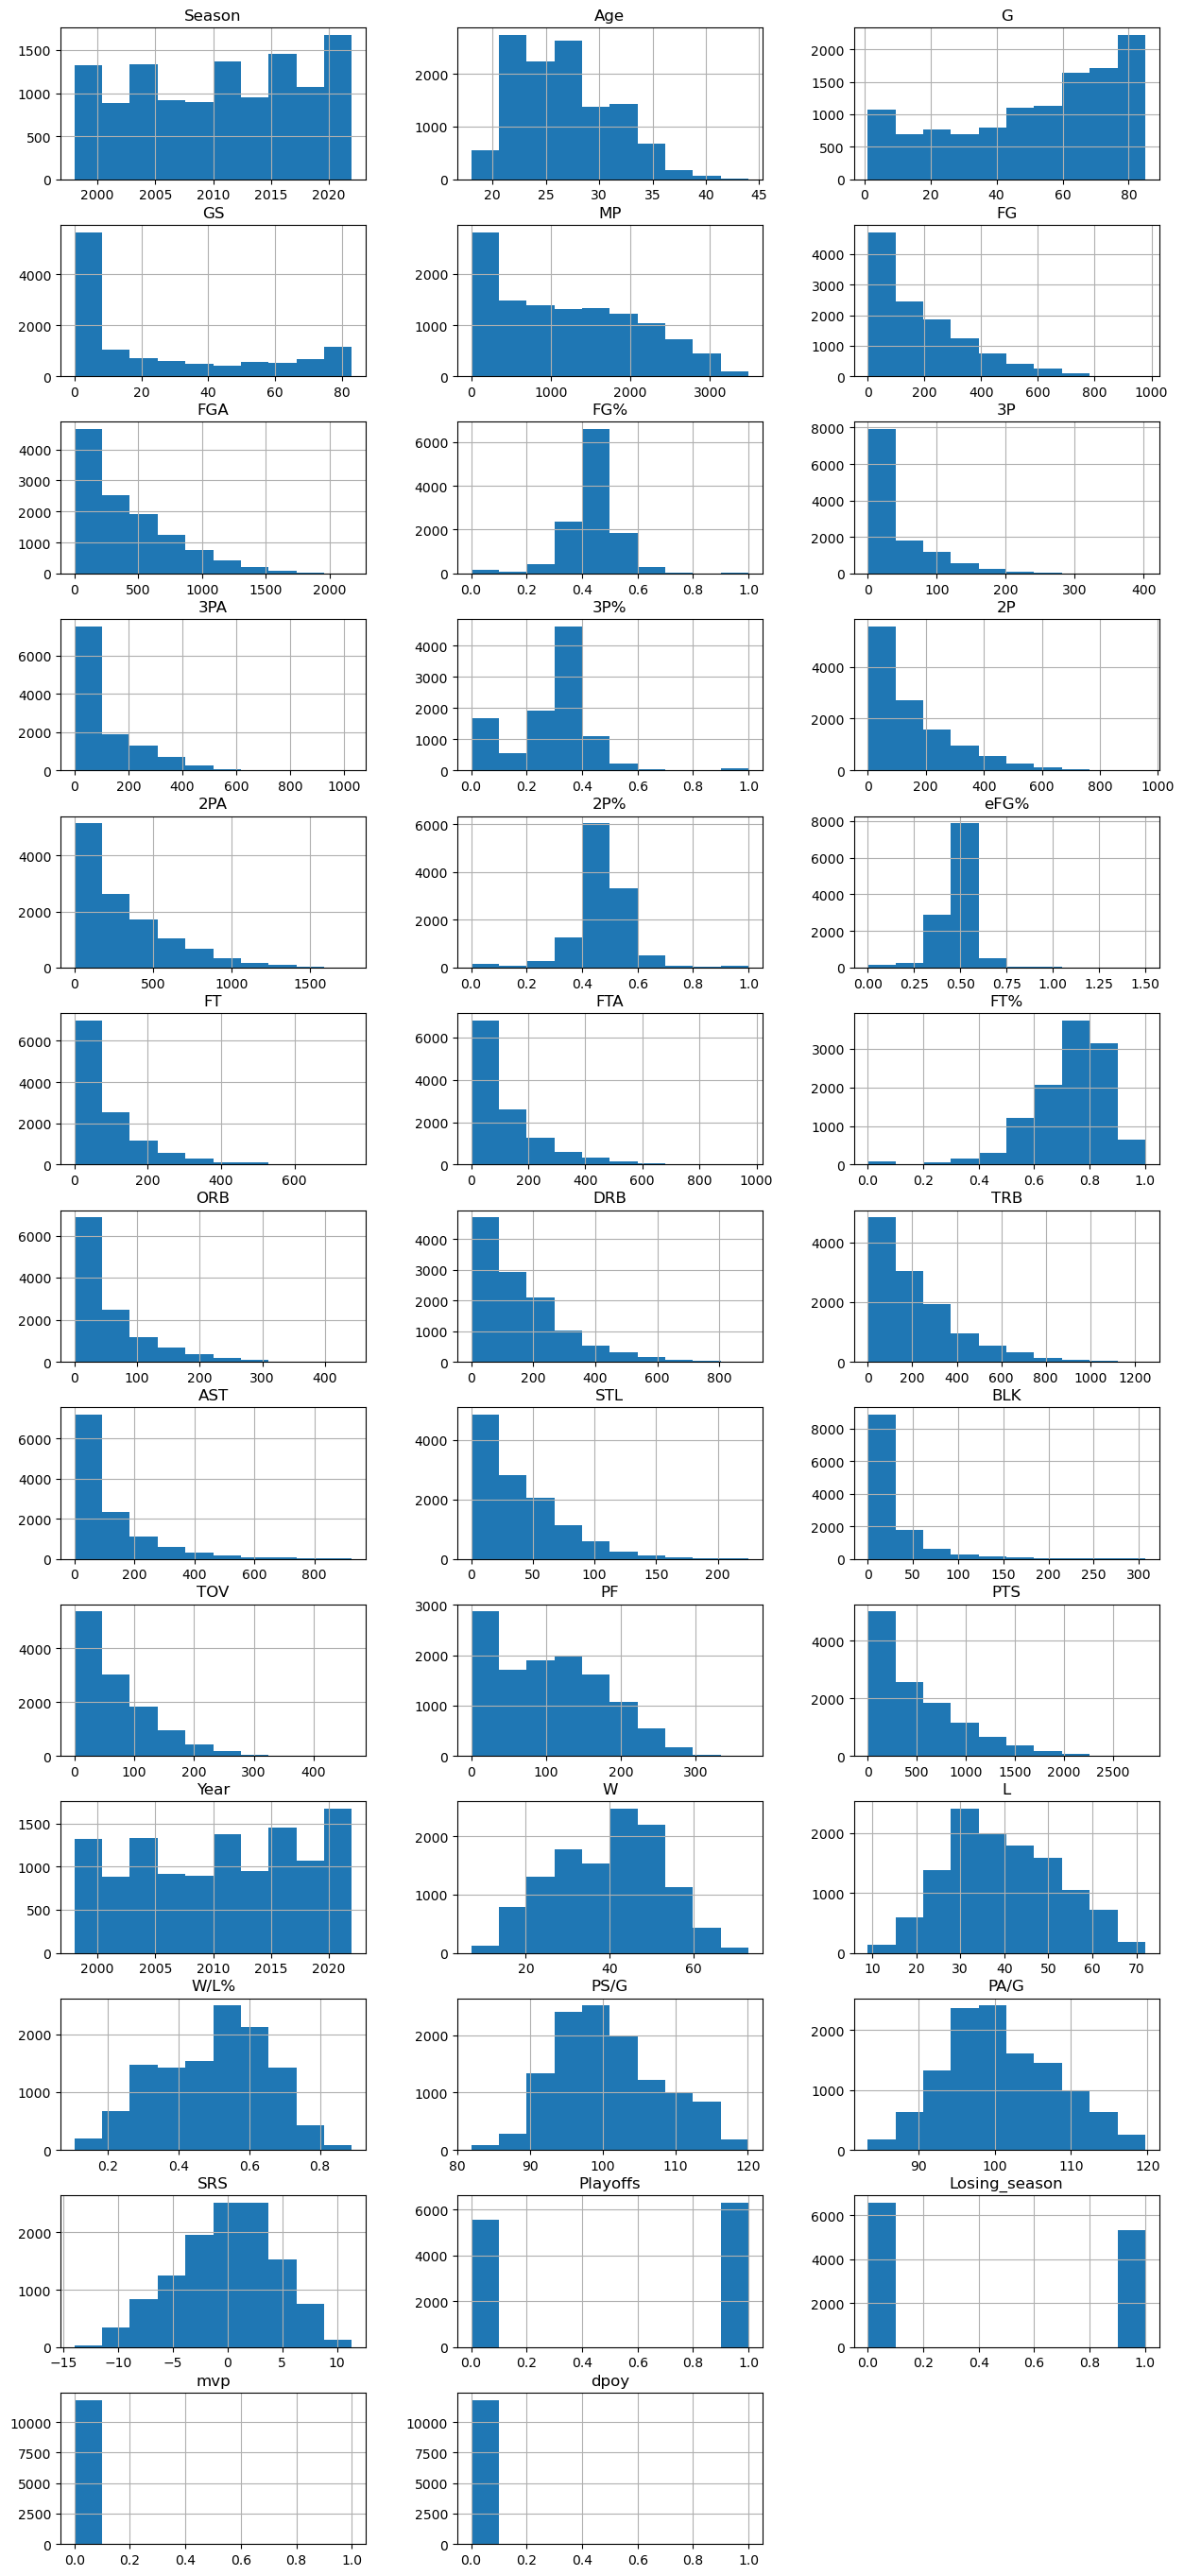

In [4]:
hist = df_num.hist(layout=(15,3),figsize=(15,40))

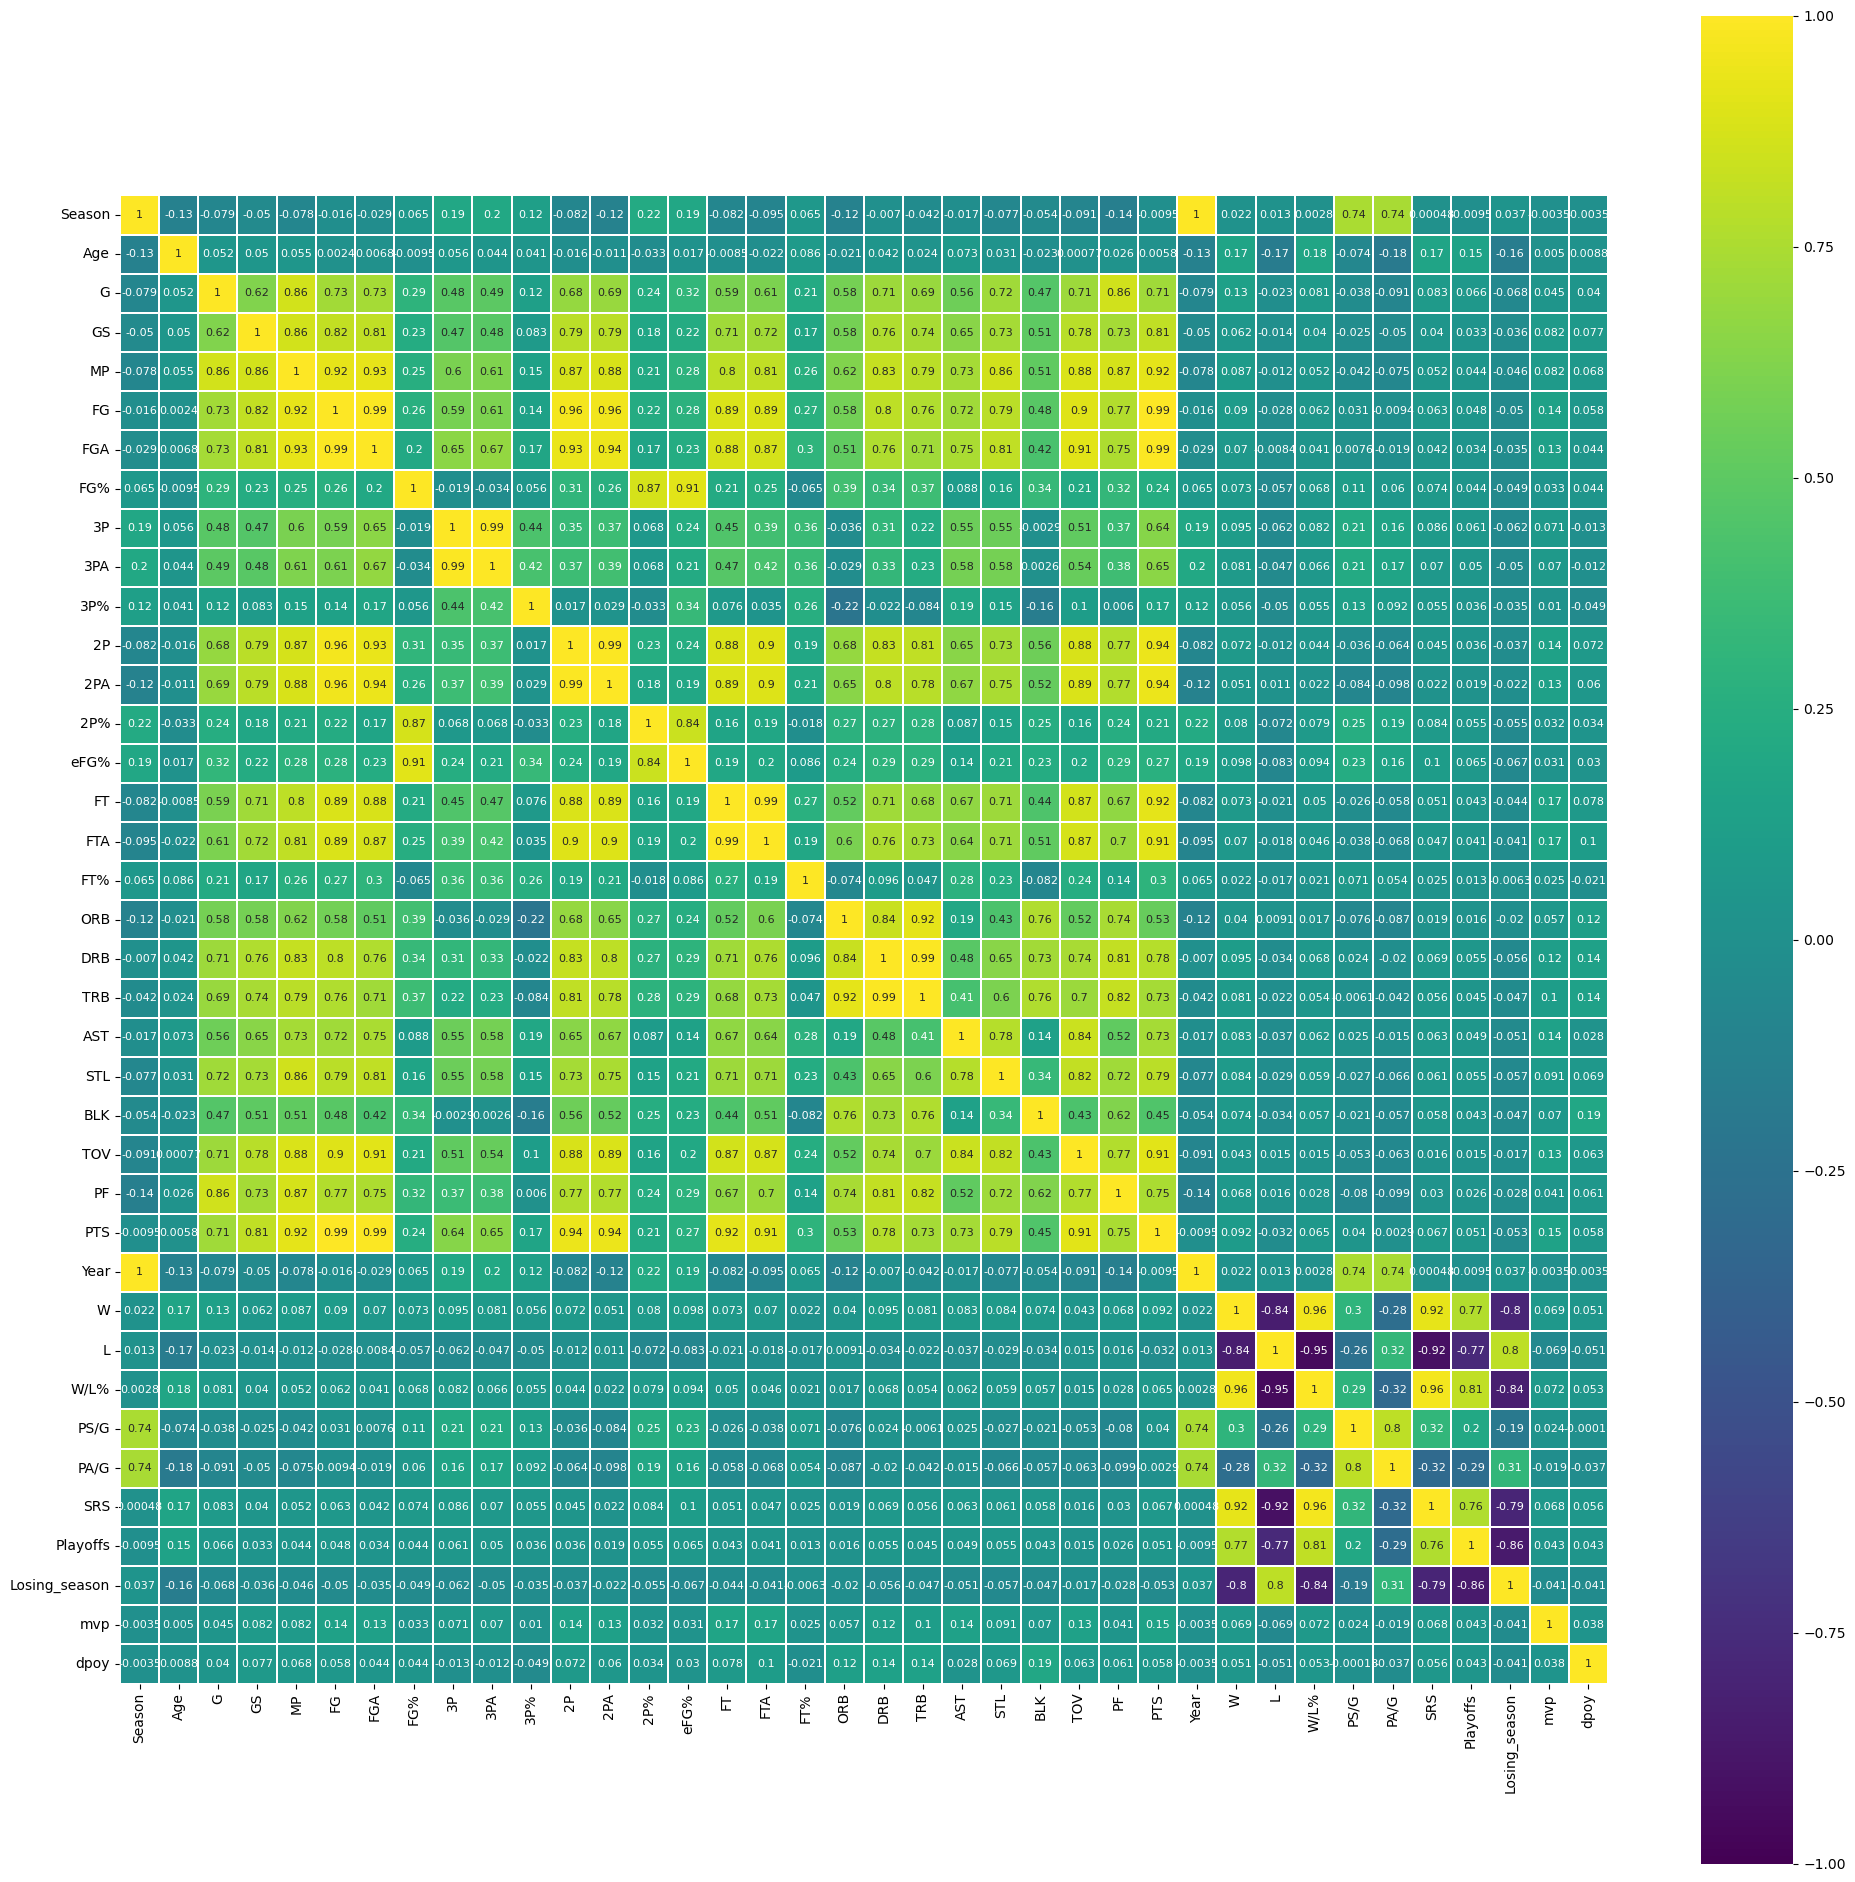

In [5]:
df_corr = players_team.corr(numeric_only = True)
plt.figure(figsize=(24, 24))

sns.heatmap(df_corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [6]:
df_corr = df_corr[['mvp','dpoy']]
golden_features_mvp_list = list(df_corr[abs(df_corr['mvp']) > 0.5].sort_values('mvp',ascending=False).index)[1:] ## remove SalePrice from list
golden_features_dpoy_list = list(df_corr[abs(df_corr['dpoy']) > 0.5].sort_values('dpoy',ascending=False).index)[1:] ## remove SalePrice from list
print("There is {} strongly correlated values with MVP:\n{}".format(len(golden_features_mvp_list), golden_features_mvp_list))
print("There is {} strongly correlated values with DPOY:\n{}".format(len(golden_features_dpoy_list), golden_features_dpoy_list))

There is 0 strongly correlated values with MVP:
[]
There is 0 strongly correlated values with DPOY:
[]


## Data Preprocessing

In [7]:
#check for missing data 
df_na = (players_team.isnull().sum() / len(players_team)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(20)

,Missing Ratio
3P%,13.859383
FT%,3.894790
2P%,0.741865
FG%,0.404654
eFG%,0.404654


Text(0.5, 1.0, 'Percent missing data by features')

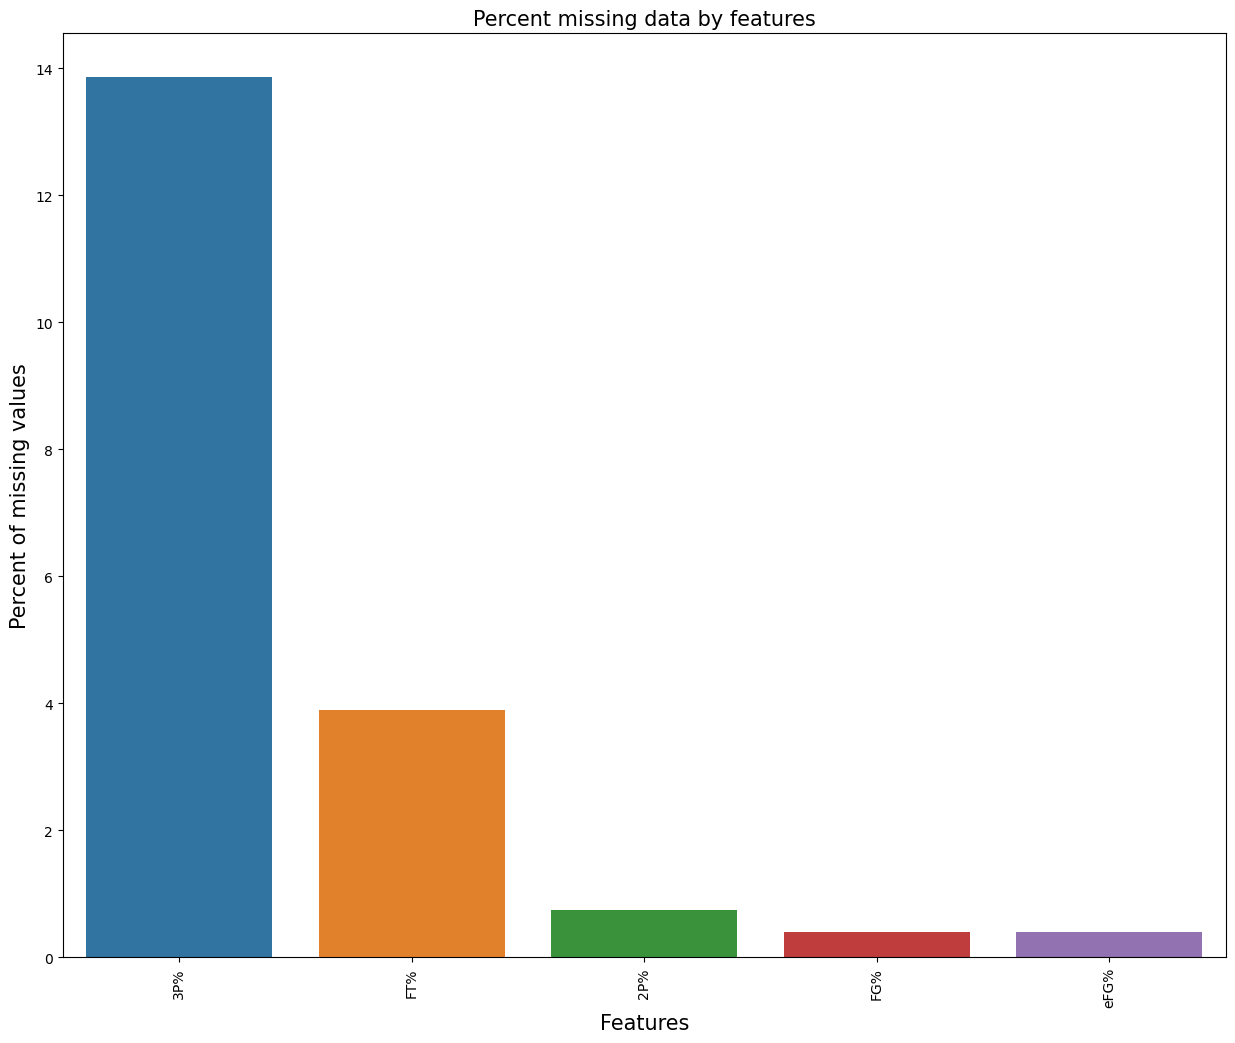

In [8]:
# Visualize the missing ratios
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=df_na.index, y=df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by features', fontsize=15)

**3P%**: the percentage of 3 pts attempts that player has made

In [9]:
#for the player who made 0 threes and score 0
players_team["3P%"] = players_team["3P%"].fillna(0)

**FT%**:the percentage of free throw sttempts that player has made

In [10]:
#for the player who made 0 free throw attmpts and score 0
players_team["FT%"] = players_team["FT%"].fillna(0)

**2P%**: the percentage of 2 pts attempts that player has made

In [11]:
#for the player who made 0 2 pts attmpts and score 0
players_team["2P%"] = players_team["2P%"].fillna(0)

**FG%**: the percentage of field goal attempts that player has made (only count for 2 pts)

In [12]:
#for the player who made 0 field goal attmpts and score 0
players_team["FG%"] = players_team["FG%"].fillna(0)

**eFG%**: the percentage of field goal attempts that player has made (count both 2 and 3 pts)

In [13]:
#for the player who made 0 attmpts and score 0
players_team["eFG%"] = players_team["eFG%"].fillna(0)

In [14]:
#check for missing data 
df_na = (players_team.isnull().sum() / len(players_team)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head()

,Missing Ratio


However, if a player has 0 eFG%, he will be an extreme outlier of the dataset, so we will remove him from the dataset

In [15]:
#remove these players
players_team = players_team[players_team["eFG%"] != 0]

In [16]:
#check 
df = players_team[players_team["eFG%"] == 0]
df["eFG%"]

Series([], Name: eFG%, dtype: float64)

## Feature Engineering

In [17]:
y_dpoy = players_team.dpoy
y_mvp = players_team.mvp
# We won't use any label information during data pre-processing and feature engineering
players_team.drop(['dpoy'], axis=1, inplace=True)
players_team.drop(['mvp'], axis=1, inplace=True)

In [18]:
from scipy.stats import skew

numeric_feats = players_team.dtypes[players_team.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = players_team[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
BLK,2.748175
AST,2.072870
FT,1.990180
FTA,1.903221
ORB,1.736578
3P,1.635772
3PA,1.481650
TRB,1.365088
DRB,1.326489
2P,1.309386


In [19]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features with enough skew to justify applying the Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    players_team[feat] += 1
    players_team[feat] = boxcox1p(df[feat], lam)

There are 36 skewed numerical features with enough skew to justify applying the Box Cox transform


**Split the data into train and test**

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(players_team, y_mvp, test_size=0.25, random_state=42)